# CSCE 556 - Data Analysis in Python: Application to Neuroscience

## Laboratory 7 - MRI

The objective of this laboratory is to get acquainted with elements of MRI data analysis in Python.



In [ ]:
# Install some required package, if they are not already installed
!pip install -q nibabel dipy brainextractor antspyx
#!pip install  #chart_studio

# Install a package written for the course that includes a few function
# useful for this lab. Normally the following line should do the trick:
#!pip install git+https://github.com/christian-oreilly/csce590.git
# However, Colab sometimes has it quirks and for some reason this does not
# work. So we git-clone and install the package ourself
%cd
!git clone https://github.com/christian-oreilly/csce590.git
%cd csce590
#!python setup.py install

/root
fatal: destination path 'csce590' already exists and is not an empty directory.
/root/csce590


For this laboratory, we will use anatomical MRI data from subject `032392` from the [LEMON dataset](https://fcon_1000.projects.nitrc.org/indi/retro/MPI_LEMON.html). For convenience, these files are downloaded within the csce590 package. Files are stored as follows:

* data
    * sub-032392
        * ses-01
            * anat
                * sub-032438_ses-01_acq-mp2rage_defacemask.nii.gz
                * sub-032438_ses-01_acq-mp2rage_T1w.nii.gz
                * sub-032438_ses-01_inv-2_mp2rage.nii.gz

The .nii.gz files are compressed (gzip) versions of neuroimaging data stored in a format known as NIfTI.

Use NiBabel to load these three MRI volumes in variables `T1w`, `inv2_mp2rage`, and `defacedmask`.

In [93]:
from pathlib import Path
import nibabel as nib
import matplotlib.pyplot as plt
import ants
import numpy as np
import seaborn as sns


##### insert your code #####
T1w = nib.load("/root/csce590/data/sub-032392/ses-01/anat/sub-032392_ses-01_acq-mp2rage_T1w.nii.gz")
inv2_mp2rage = nib.load("/root/csce590/data/sub-032392/ses-01/anat/sub-032392_ses-01_inv-2_mp2rage.nii.gz")
defacedmask = nib.load("/root/csce590/data/sub-032392/ses-01/anat/sub-032392_ses-01_acq-mp2rage_defacemask.nii.gz")

############################


The `defacedmask` contains the information about the voxels that have been zeroed out to anonymize the MRI image (to remove the faces of the participants so that they cannot be identified by their facial structure).

In the cell below, we apply the intensity nonuniformity (NU) correction. For this correction, we need to exclude the voxels that have been zeroed out by the defacing. This can be done using the `defacedmask` volume. (This operation will take about 3 minutes.)

In [94]:
%%time
# We invert the mask because we want to select non-zeroed-out voxels,
# not zeroed-out voxels.
inv_defacedmask = nib.Nifti1Image(1-defacedmask.get_fdata(),
                                  defacedmask.affine,
                                  defacedmask.header)
inv_defacedmask = ants.from_nibabel(inv_defacedmask)

T1w_nu = ants.n4_bias_field_correction(ants.from_nibabel(T1w), mask=inv_defacedmask)\
             .to_nibabel()

CPU times: user 2min 2s, sys: 826 ms, total: 2min 3s
Wall time: 1min 11s


Using `BrainExtractor` from the `brainextractor` package, compute a mask for the brain. This operation requires the use of the `inv2_mp2rage` volume. (This operation will take about 1 minute to run.)

In [95]:
%%time
from brainextractor import BrainExtractor

##### insert your code #####

brain_extractor = BrainExtractor(inv2_mp2rage)

brain_extractor.run()
mask = brain_extractor.compute_mask()

############################

Initializing...
Parameters: bt=0.500000, d1=20.000000, d2=10.000000, rmin=3.330000, rmax=10.000000
tmin: 0.000000, t2: 0.000000, t: 38.000000, t98: 380.000000, tmax: 826.000000
Center-of-Mass: [ 90.09423365 122.85945511 124.90447124]
Head Radius: 95.473147
Median within Head Radius: 231.000000
Initializing surface...
Brain extractor initialization complete!
Running surface deformation...

Complete.
CPU times: user 29.8 s, sys: 19.6 s, total: 49.4 s
Wall time: 28.1 s


CPU times: user 350 ms, sys: 94.8 ms, total: 445 ms
Wall time: 444 ms


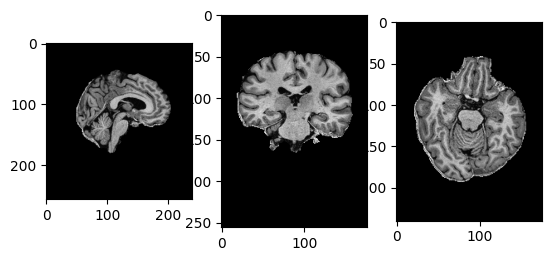

In [96]:
%%time
from dipy.segment.tissue import TissueClassifierHMRF

##### insert your code #####
data = T1w_nu.get_fdata()
masked_data = data.copy()
masked_data[~mask.astype(bool)] = 0

fig, axes = plt.subplots(1,3)

for dim, ax in enumerate(axes):
  ax.imshow(masked_data.take(int(masked_data.shape[dim]/2), axis=dim).T[::-1, :], cmap='gray')


Using `TissueClassifierHMRF` from `dipy.segment.tissue`, classify the tissues from the masked T1w_nu volume as CSF, white matter, and gray matter. Use only ten iterations in `TissueClassifierHMRF.classify()` (i.e., use the argument `max_iter=10`) to avoid making the computation too long. The default value for this argument is 100. With `max_iter=10`, this operation will take about 2 minutes.

>> Iteration: 0
>> Iteration: 1
>> Iteration: 2
>> Iteration: 3
>> Iteration: 4
>> Iteration: 5
>> Iteration: 6
>> Iteration: 7
>> Iteration: 8
>> Iteration: 9
CPU times: user 40.4 s, sys: 11.1 s, total: 51.5 s
Wall time: 51.6 s


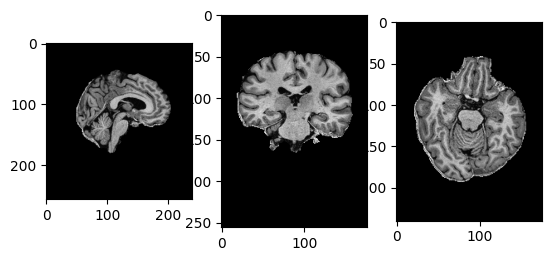

In [97]:
%%time
from dipy.segment.tissue import TissueClassifierHMRF

##### insert your code #####
data = T1w_nu.get_fdata()
masked_data = data.copy()
masked_data[~(mask.astype(bool))] = 0



fig, axes = plt.subplots(1,3)

for dim, ax in enumerate(axes):
  ax.imshow(masked_data.take(int(masked_data.shape[dim]/2), axis=dim).T[::-1, :], cmap='gray')


nclass = 3
beta = 0.1
hmrf = TissueClassifierHMRF()

initial_segmentation, final_segmentation, PVE = hmrf.classify(masked_data, nclass, beta, max_iter=10)

############################

Display the middle slice along the three main anatomical planes for `T1w_nu`, `inv2_mp2rage`, skull-stripped `T1w_nu`, and the segmentation of the CSF, white matter, and gray matter. Using sns.kdeplot, also show the distribution of the T1w_nu values for the three types of tissues classified.

This figure should look similar (not the same since the figure shown here was done for a different subject) to this:

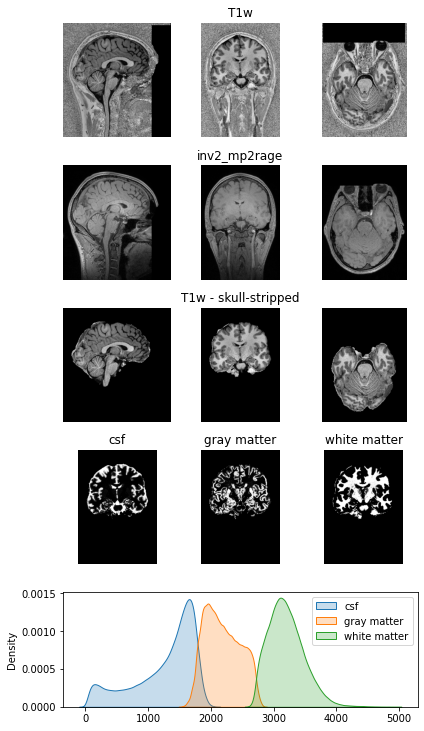

Send this figure to me, along with the .py file for this notebook.

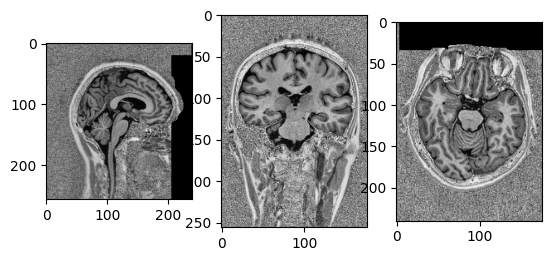

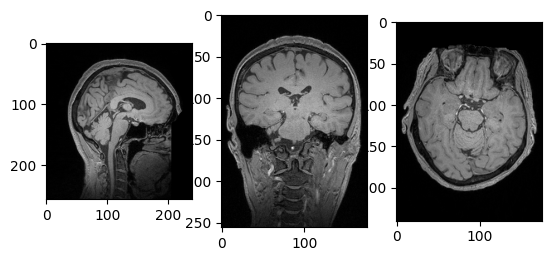

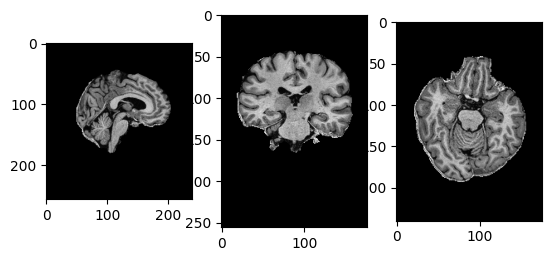

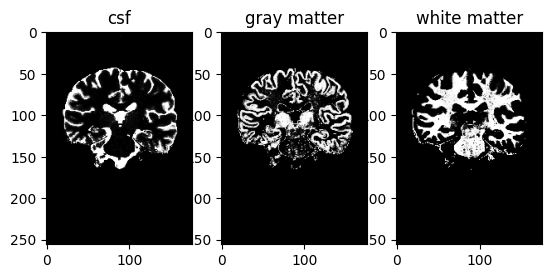

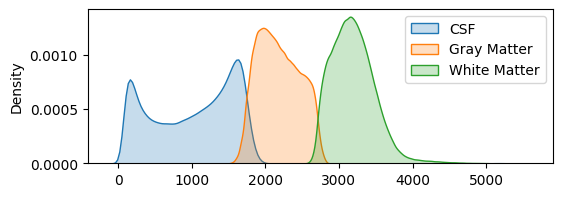

In [98]:
import numpy as np
import matplotlib.pyplot as plt
##### insert your code #####

fig, axes = plt.subplots(1,3)
for dim, ax in enumerate(axes):
  ax.imshow(data.take(int(data.shape[dim]/2), axis=dim).T[::-1, :], cmap='gray')

fig, axes = plt.subplots(1,3)
for dim, ax in enumerate(axes):
  ax.imshow(inv2_mp2rage.get_fdata().take(int(inv2_mp2rage.get_fdata().shape[dim]/2), axis=dim).T[::-1, :], cmap='gray')

fig, axes = plt.subplots(1,3)
for dim, ax in enumerate(axes):
  ax.imshow(masked_data.take(int(masked_data.shape[dim]/2), axis=dim).T[::-1, :], cmap='gray')

fig, axes = plt.subplots(1,3)
for dim, (ax, tissue) in enumerate(zip(axes, ['csf', 'gray matter', 'white matter'])):
  ax.imshow(PVE.take(int(masked_data.shape[1]/2), axis=1)[..., dim].T[::-1, :], cmap='gray')
  ax.set_title(tissue)

fig, axes = plt.subplots(1,1,figsize=(6, 2))
csf_values = T1w_nu.get_fdata()[final_segmentation == 1]  # CSF
gm_values = T1w_nu.get_fdata()[final_segmentation == 2]  # Gray Matter
wm_values = T1w_nu.get_fdata()[final_segmentation == 3]  # White Matter

sns.kdeplot(csf_values, label='CSF', fill=True)
sns.kdeplot(gm_values, label='Gray Matter', fill=True)
sns.kdeplot(wm_values, label='White Matter', fill=True)

plt.ylabel('Density')
plt.legend()

plt.show()

fig.tight_layout()
############################